In [1]:
from keras.optimizers import SGD, Adam, Adamax
from keras.models import model_from_json
import tensorflow as tf

import numpy as np


Using TensorFlow backend.


In [2]:
from keras.utils.np_utils import to_categorical
import pandas as pds
def load_data(csv_path, shuffle=True):
    dat = pds.read_csv(csv_path)
    x_origin = dat.iloc[:, range(0, 6*20)].values
    y_origin = dat.loc[:, 'collision_system'].values
    if shuffle == True:
        randomize = np.arange(len(x_origin))
        np.random.shuffle(randomize)
        x = x_origin[randomize]
        y = y_origin[randomize]

    #x, y, randomize = regulize(x_origin, y_origin)
    return x, y
x_test, y_test = load_data('testing_data.csv')
y_test = to_categorical(y_test)

n_test = len(x_test)

In [6]:
# load json and create model
with open('model_filter.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("weights_filter.hdf5")

adm = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=adm,
              metrics=['accuracy'])

height, width = 20, 6


In [7]:
x_test = x_test.reshape(n_test, height, width, 1).astype('float32')

err, acc = loaded_model.evaluate(x_test, y_test, batch_size=1)

print('predict err=%s, acc=%s'%(err, acc))


5950/5971 [============================>.] - ETA: 0spredict err=0.6466877739736132, acc=0.6343995980572769


In [8]:
classes = loaded_model.predict_classes(x_test)

y_true = np.argmax(y_test, axis=1)
y_pred = classes

dat_sources = {'ppb': y_true == 0,
               'pbpb': y_true == 1}

for key in dat_sources.keys():
    ids = dat_sources[key]
    print(key)
    correct_ones = np.count_nonzero(y_true[ids] == y_pred[ids])
    print(correct_ones, ' out of ', ids.sum(), 'is correct', 'ratio=', correct_ones/float(ids.sum()))
    print('')


5696/5971 [===========================>..] - ETA: 0sppb
2672  out of  3296 is correct ratio= 0.8106796116504854

pbpb
1116  out of  2675 is correct ratio= 0.417196261682243



In [32]:
5792/5971 [============================>.] - ETA: 0sppb
2696  out of  3296 is correct ratio= 0.8179611650485437

pbpb
1101  out of  2675 is correct ratio= 0.41158878504672897


5792/5971 [============================>.] - ETA: 0sppb
2671  out of  3296 is correct ratio= 0.810376213592233

pbpb
1116  out of  2675 is correct ratio= 0.417196261682243




76192/76371 [============================>.] - ETA: 0sppb
54663  out of  76370 is correct ratio= 0.7157653528872594
 0.72055

SyntaxError: invalid syntax (<ipython-input-32-cf47820c84c3>, line 1)

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


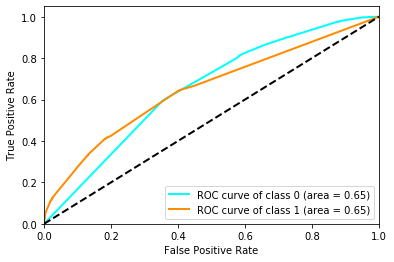

In [43]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
n_classes=2
lw = 2
y_score = loaded_model.predict(x_test) 

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


